# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
> 
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [12]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

import matplotlib.pyplot as plt
from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the frame. 
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \text{ cm}$ and the wheel radius is $r = 12.5 \text{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [23]:
l = 0.5
r = 0.125 

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [14]:

def draw_scooter(x, y, theta):
  #Coordonates of the center of the right wheel
  x1 = x + sin(theta)*l/2
  y1 = y - cos(theta)*l/2

  #Coordonates of the center of the left wheel
  x2 = x - sin(theta)*l/2
  y2 = y + cos(theta)*l/2

  #coordonnées du centre du scooter et sommet des deux triangles
  middle_x = (x1 + x2) / 2
  middle_y = (y1 + y2) / 2
  #coordonnées pour triangle 1 
  x_tri11 = x1 + r*cos(theta)
  y_tri11 = y1 + r*sin(theta)
  x_tri12 = x1 - r*cos(theta)
  y_tri12 = y1 - r*sin(theta)
  #coordonnées pour triangle 2 
  x_tri21 = x2 - r*cos(theta)
  y_tri21 = y2 - r*sin(theta)
  x_tri22 = x2 + r*cos(theta)
  y_tri22 = y2 + r*sin(theta)

  #Wheel de droite
  x1_ = linspace(x1-cos(theta)*r,x1+cos(theta)*r, 100)
  y1_ = linspace(y1-sin(theta)*r,y1+sin(theta)*r, 100)

  plt.plot(x1_, y1_, 'r-', linewidth=4)

  #Wheel de gauche
  x2_ = linspace(x2-cos(theta)*r,x2+cos(theta)*r, 100)
  y2_ = linspace(y2-sin(theta)*r,y2+sin(theta)*r, 100)

  plot(x2_, y2_, 'r-', linewidth = 4)
  # SCOOOOOOTER
  # Define vertices for the first triangle
  triangle1_vertices = [[x_tri11, middle_x,x_tri12 ], [y_tri11, middle_y,y_tri12 ]]

  # Define vertices for the second triangle
  triangle2_vertices = [[x_tri21, middle_x,x_tri22 ], [y_tri21, middle_y,y_tri22 ]]

  # Create polygons
  polygon1 = Polygon(np.array(triangle1_vertices).T, closed=True, color='black', alpha=1)
  polygon2 = Polygon(np.array(triangle2_vertices).T, closed=True, color='black', alpha=1)

  # Add polygons to plot
  plt.gca().add_patch(polygon1)
  plt.gca().add_patch(polygon2)
  #add the circle thing  
  cercle = Circle((x + 0.5*cos(theta), y+0.5*sin(theta)), 0.03, color='green')
  plt.gca().add_patch(cercle)
  

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [15]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

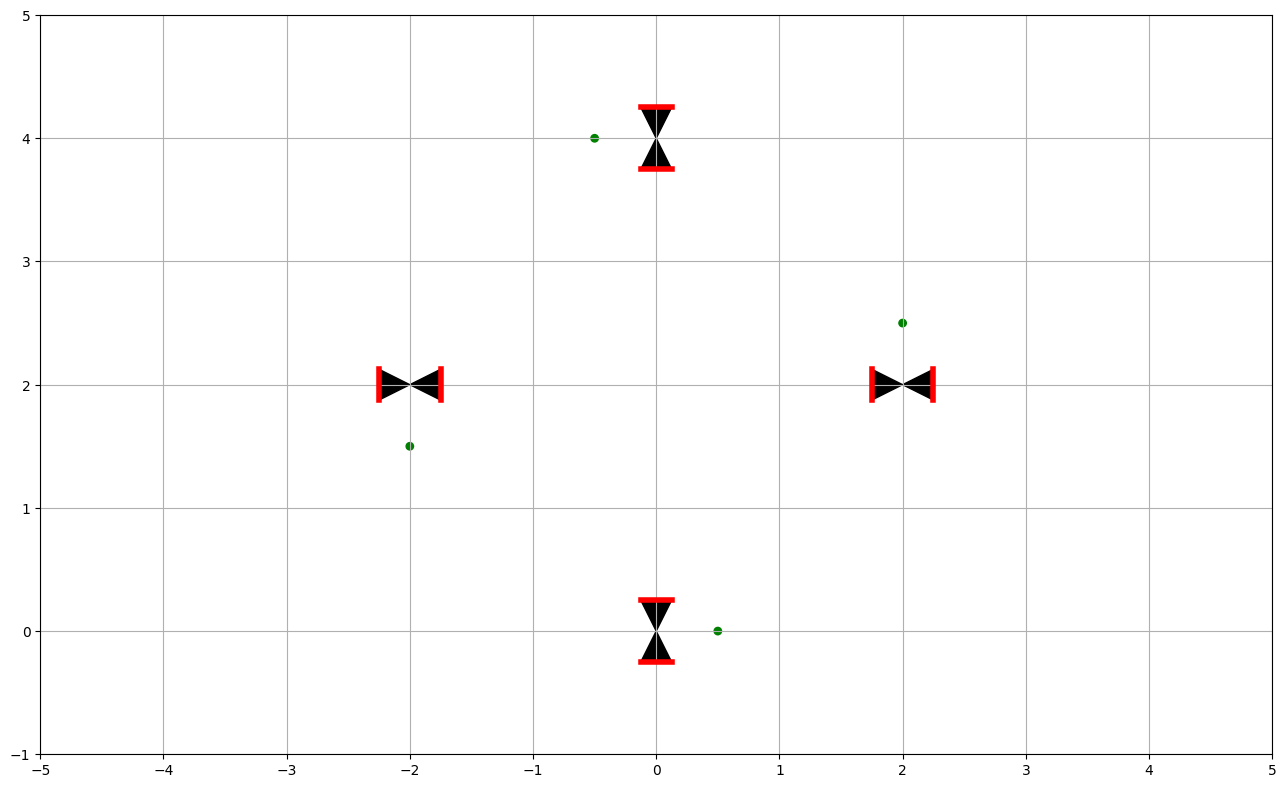

In [16]:
draw_arena(-5,5,-1,5)
draw_scooter(0,0,0)
draw_scooter(2, 2, np.pi/2)
draw_scooter(0, 4, np.pi)
draw_scooter(-2, 2, 3*np.pi/2)

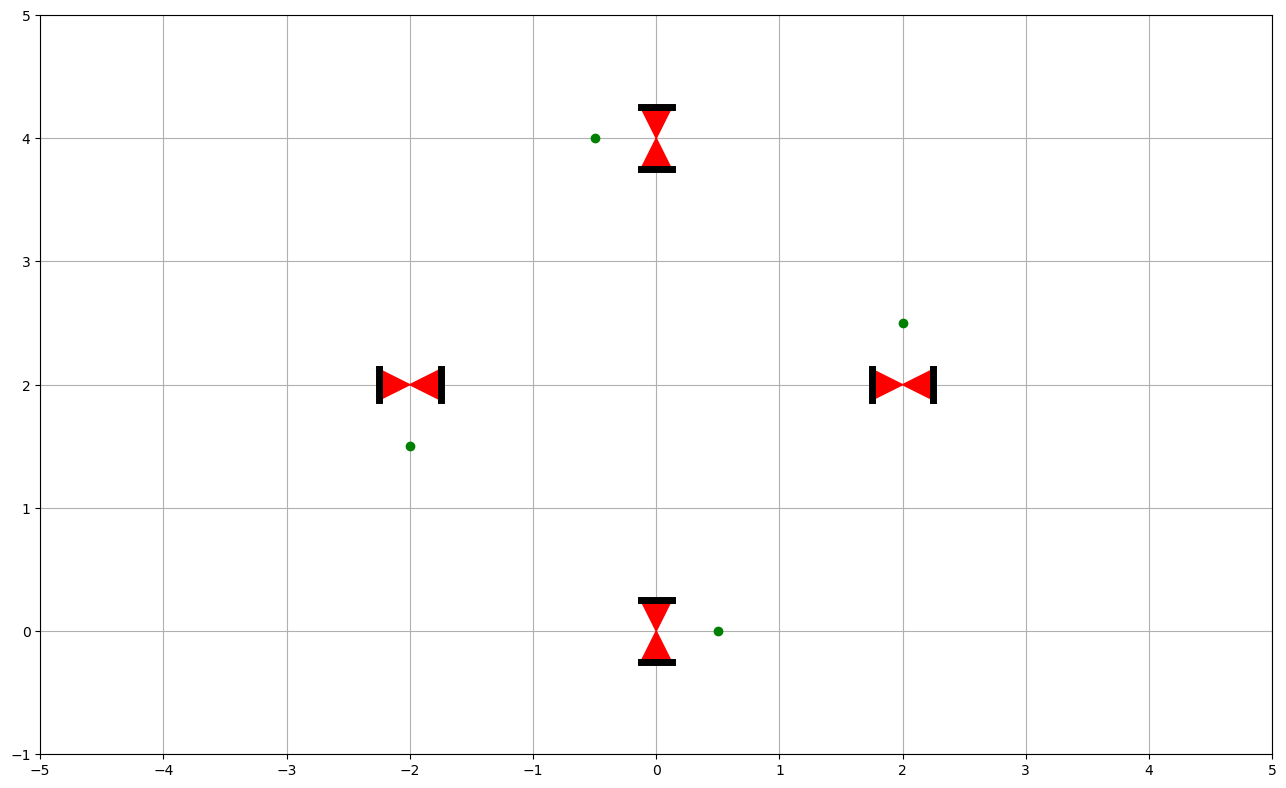

In [5]:
pass

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

le véhicule est motorisé par 2 roues motrices. 
Soit alors la roue droite de rayon r de centre Or , de vitesse de rotation wr et de vitesse de translation vr, on a bien la relation vr = r * wr, de même on a la roue gauche de rayon r de centre Og, de vitesse de rotation wg et de vitesse de translation vg, on a bien la relation vg = r * wg. 
La distance entre les 2 roues est OrOg = l, la norme de la vitesse de translation du véhicule est V = r  * ($\omega_d$ + $\omega_l$) / 2 .
soit le point M le milieu du segment [Og, Or].
Lorsque vd>vg le véhicule va faire une rotation suivant l'axe (I, y), avec I le centre de giration du véhicule
Les points I Or Og et M sont toujours  colinéaires a chaque instant t, soit M0 la position du point M à l'instant t0 = 0 où le véhicule se trouve dans sa position initiale définie précédemment. on définit teta comme l'ongle entre IM et IM0, la vitesse w = teta * t = r*(wd-wg)/l . 
on obtient finalement x(t)= V * cos(tetha)*t et  y(t)= V * sin(tetha)*t .
donc :

V = r  * ($\omega_l$ + $\omega_d$) / 2

$\dot{x}$ = r /2 * cos($\theta$)*($\omega_d$ + $\omega_l$)

$\dot{y}$= r /2 * sin($\theta$)*($\omega_d$+$\omega_l$)

$\dot{\theta}$ = r /$\ell$ * ($\omega_d$-$\omega_l$)

**TODO**

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

**TODO**

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**TODO**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [17]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [18]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = r * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = r * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = r * (omega_r - omega_l) / l
    return array([dx, dy, dtheta])

### Configuration de la simulation

🧩 Simuler la dynamique du fauteuil roulant pendant 4 secondes lorsque $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$, et que les vitesses des roues sont constantes, avec $\omega_l = \left(1 - \frac{\ell}{4}\right) \frac{\pi}{r} \, \text{rad/s}$ et $\omega_r = \left(1 + \frac{\ell}{4}\right) \frac{\pi}{r} \, \text{rad/s}$. (Calculer les sorties denses.)


In [19]:
S = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)
print(S)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             1.111e+00  2.737e+00  4.000e+00]
        y: [[ 0.000e+00  3.142e-04 ... -1.830e+00  1.003e-03]
            [ 0.000e+00  2.467e-08 ...  2.804e+00  7.269e-04]
            [ 0.000e+00  1.571e-04 ...  4.299e+00  6.283e+00]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001A3CB5B5E90>
 t_events: None
 y_events: None
     nfev: 44
     njev: 0
      nlu: 0


🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

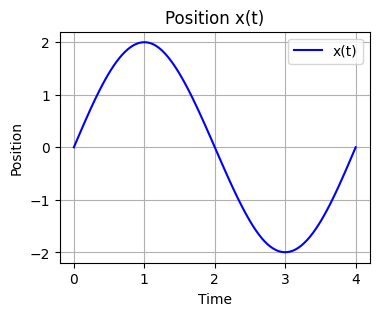

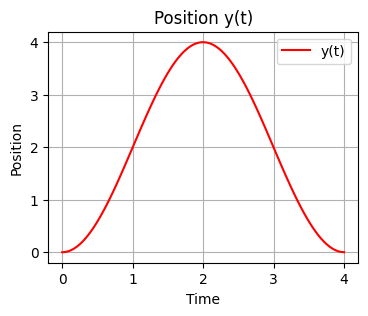

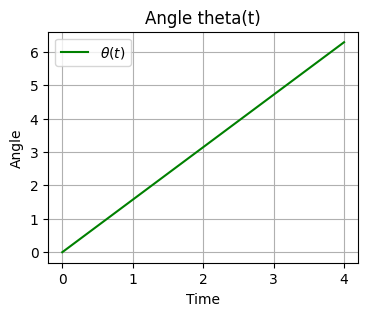

In [20]:
t = linspace(0.0, 4.0, 100)
x, y, theta = S["sol"](t)

# Plotting x(t)
plt.figure(figsize=(4, 3))
plt.plot(t, x, label="x(t)", color='b')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position x(t)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting y(t)
plt.figure(figsize=(4, 3))
plt.plot(t, y, label="y(t)", color='r')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position y(t)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting theta(t)
plt.figure(figsize=(4, 3))
plt.plot(t, theta, label=r"$\theta(t)$", color='g')
plt.xlabel('Time')
plt.ylabel('Angle')
plt.title('Angle theta(t)')
plt.legend()
plt.grid(True)
plt.show()

🧩 Use the simulation results to display the robot location every 0.5 second.

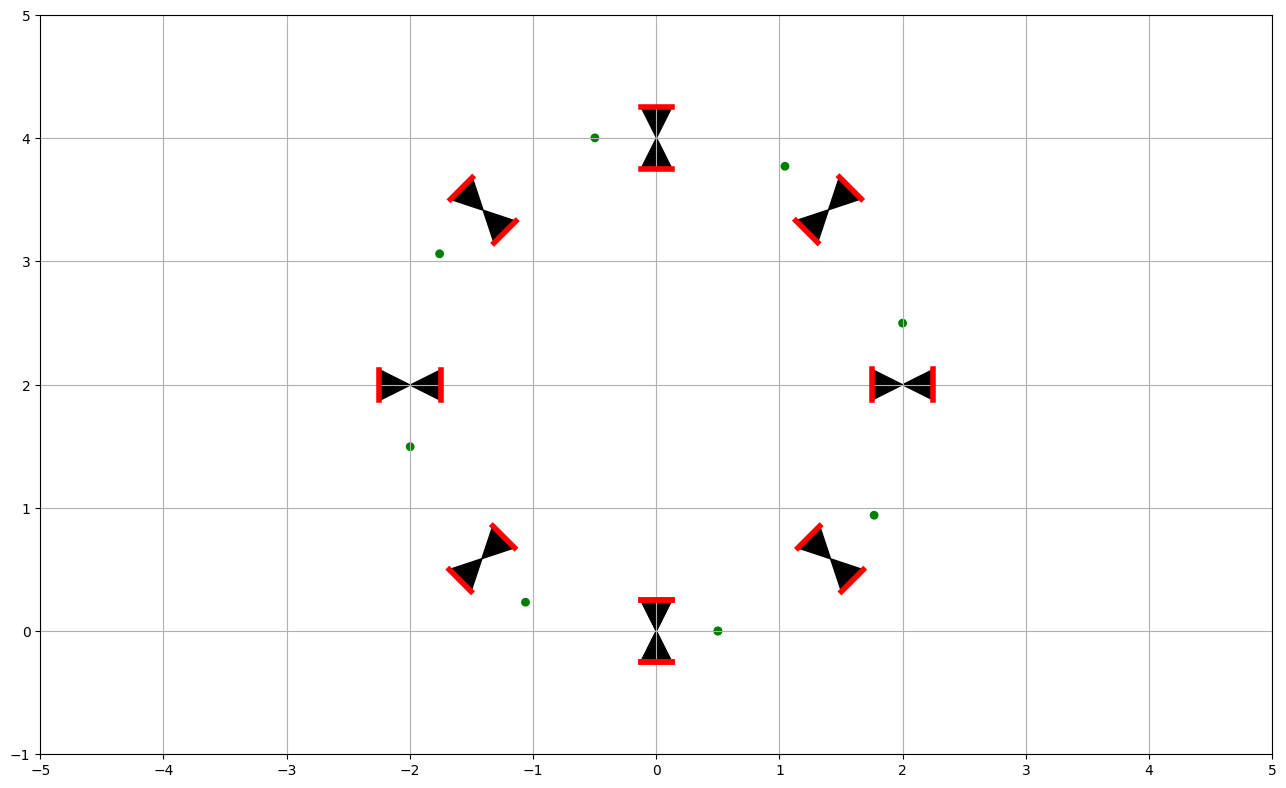

In [24]:
l = 0.5
r = 0.125 
draw_arena(-5,5,-1,5)
t = linspace(0, 4, 9)
solution = S["sol"](t)
for x, y, theta in solution.T:
    draw_scooter(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

on rappelle que :

V = $\frac{r . ( \omega_l  +  \omega_d)}{2}$

$\dot{x}$ = $\frac{r .  cos(\theta) . (\omega_d + \omega_l) }{2}$

$\dot{y}$= $\frac{r .  sin(\theta) . (\omega_d + \omega_l) }{2}$

$\dot{\theta}$ = $\frac{r  . (\omega_d-\omega_l)}{\ell}$

avec $\theta = \omega . t $ avec un integration par rapport au temps on obtient en tenant en compte les condition initiale :

$ x(t) $ =  $2.sin(\frac{\pi}{2}.t)$

$ y(t) $ =  $-2.cos(\frac{\pi}{2}.t)+2$

$\theta $ = $\frac{\pi}{2} . t$




🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

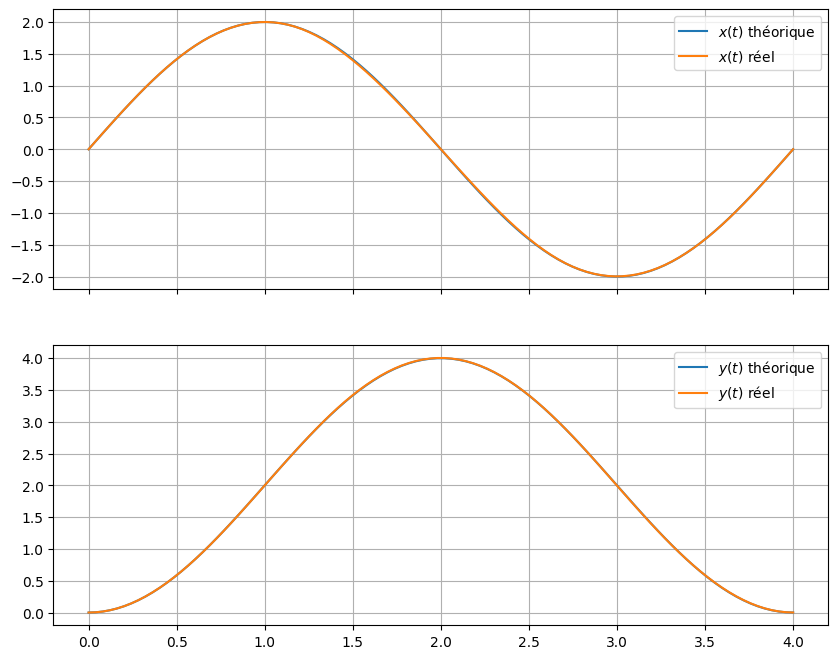

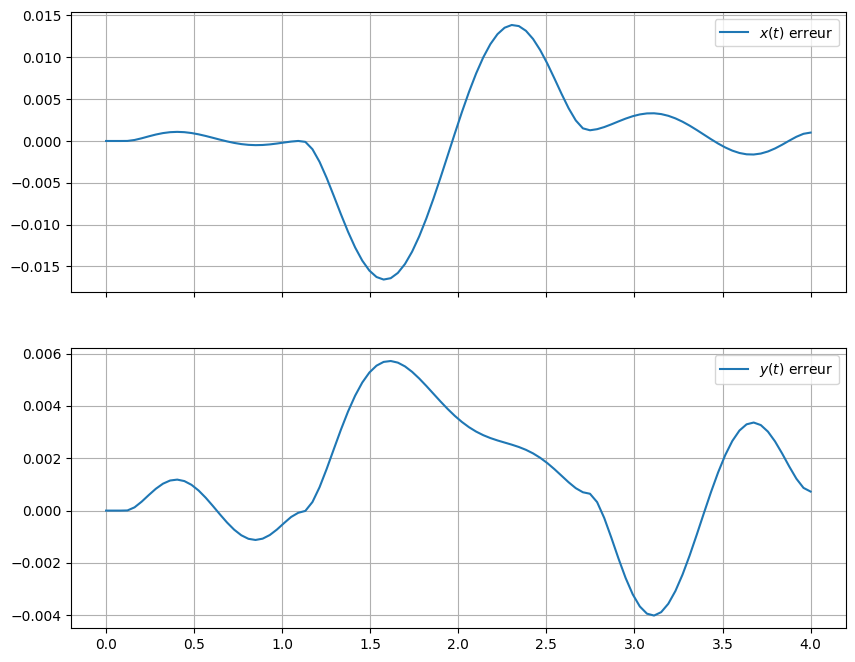

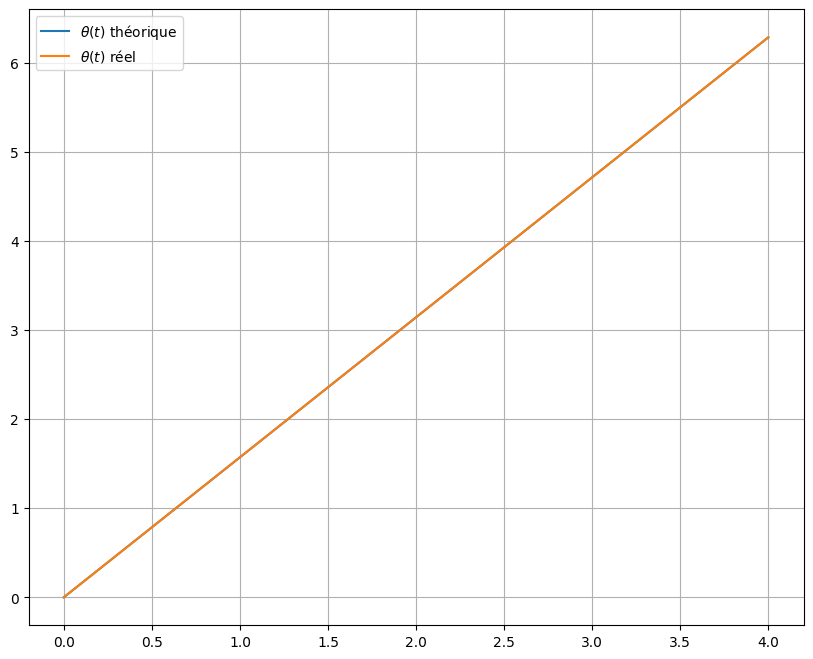

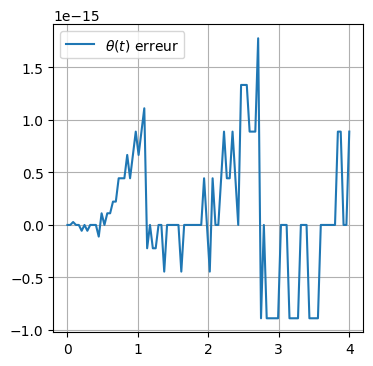

In [26]:


# Définir les valeurs de t
t = linspace(0.0, 4.0, 100)

# Valeurs théoriques de x(t), y(t), et theta(t)
xt_theoretical = 2 * sin(pi * t / 2)
yt_theoretical = -2 *cos(pi * t / 2) + 2
thetat_theoretical = (pi / 2) * t

# Valeurs réelles de x(t), y(t), et theta(t) à partir de S["sol"]
xt_real, yt_real, thetat_real = S["sol"](t)

# Calcul des erreurs
xt_error = xt_real - xt_theoretical
yt_error = yt_real - yt_theoretical
thetat_error = thetat_real - thetat_theoretical

# Création de la figure pour x(t) et y(t)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot pour x(t)
ax1.grid(True)
ax1.plot(t, xt_theoretical, label="$x(t)$ théorique")
ax1.plot(t, xt_real, label="$x(t)$ réel")
ax1.legend()

# Plot pour y(t)
ax2.grid(True)
ax2.plot(t, yt_theoretical, label="$y(t)$ théorique")
ax2.plot(t, yt_real, label="$y(t)$ réel")
ax2.legend()

# Affichage de la figure pour x(t) et y(t)
plt.show()

# Création de la figure pour les erreurs de x(t) et y(t)
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot pour l'erreur de x(t)
ax3.grid(True)
ax3.plot(t, xt_error, label="$x(t)$ erreur")
ax3.legend()

# Plot pour l'erreur de y(t)
ax4.grid(True)
ax4.plot(t, yt_error, label="$y(t)$ erreur")
ax4.legend()

# Affichage de la figure pour les erreurs de x(t) et y(t)
plt.show()

# Création de la figure pour theta(t)
fig, ax5 = plt.subplots(figsize=(10, 8))

# Plot pour theta(t)
ax5.grid(True)
ax5.plot(t, thetat_theoretical, label=r"$\theta(t)$ théorique")
ax5.plot(t, thetat_real, label=r"$\theta(t)$ réel")
ax5.legend()

# Affichage de la figure pour theta(t)
plt.show()

# Création de la figure pour l'erreur de theta(t)
fig, ax6 = plt.subplots(figsize=(4, 4))

# Plot pour l'erreur de theta(t)
ax6.grid(True)
ax6.plot(t, thetat_error, label=r"$\theta(t)$ erreur")
ax6.legend()

# Affichage de la figure pour l'erreur de theta(t)
plt.show()


🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$. 

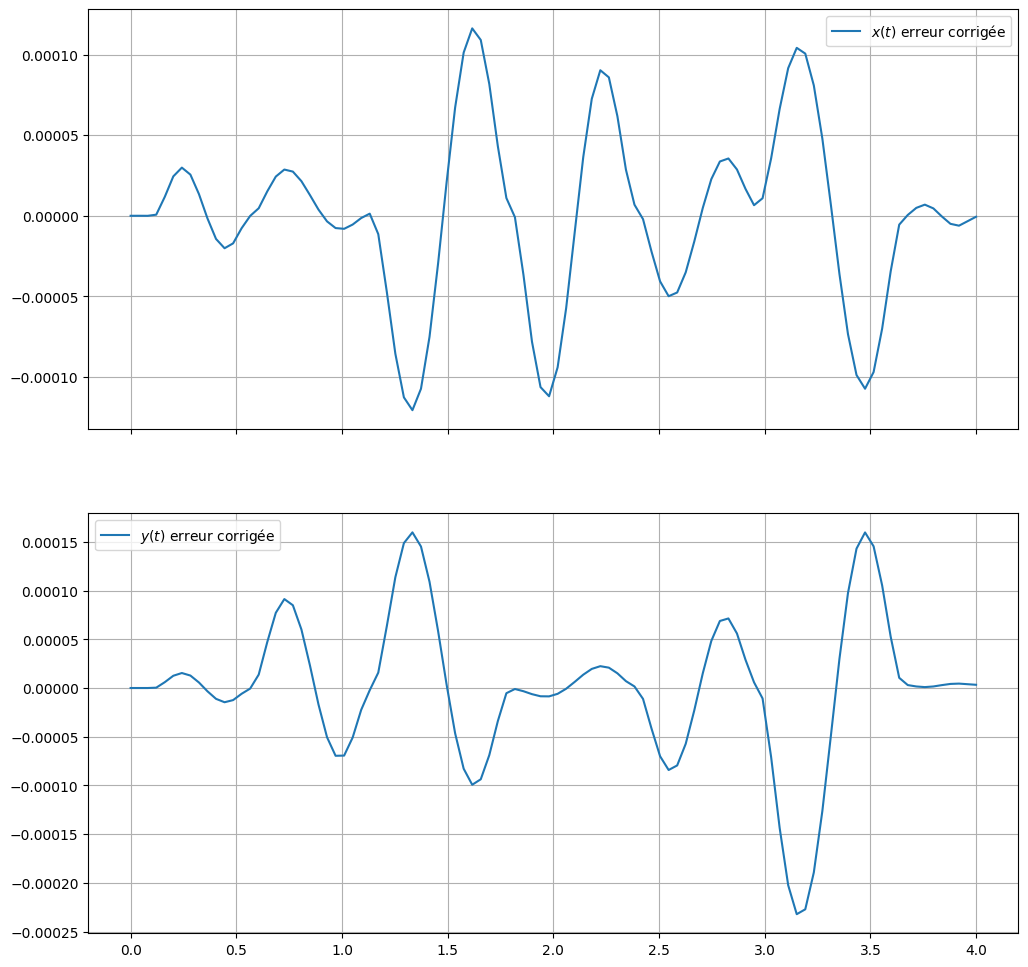

In [33]:

t = linspace(0.0, 4.0, 100)
S_corr = solve_ivp(fun=fun, t_span=(0.0, 4.0), y0=[0.0, 0.0, 0.0], rtol=1e-5, dense_output=True)
#rtol tolerence relative pour la convergence de la solution
xt, yt, _ = S_corr["sol"](t)

# Plot the errors for x(t) and y(t) separately
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax1.grid(True)
ax1.plot(t, xt - xt_theoretical, label="$x(t)$ erreur corrigée")
ax1.legend()
ax2.grid(True)
ax2.plot(t, yt - yt_theoretical, label="$y(t)$ erreur corrigée")
ax2.legend()

plt.show()